In [210]:
import matplotlib.pyplot as plt
plt.figure()
plt.show()
plt.close()
plt.rcParams.update({'font.size':16})

<Figure size 640x480 with 0 Axes>

In [211]:
import phenom

In [212]:
import pycbc.waveform
import numpy as np
import sklearn.cluster
from scipy.interpolate import InterpolatedUnivariateSpline as IUS
import sklearn.decomposition
import sklearn.mixture

In [213]:
# so we can specify minimum cluster size
from k_means_constrained import KMeansConstrained

In [214]:
import corner

In [565]:
n_samples = 1000
# n_samples = 10000
mtot = 100
qs = np.random.uniform(1, 4, n_samples)
# chieffs = np.random.uniform(-1, 1, n_samples)
chi1s = np.random.uniform(-1, 1, n_samples)
chi2s = np.random.uniform(-1, 1, n_samples)
m1s, m2s = phenom.m1_m2_M_q(mtot, qs)
# cos_inc = np.random.uniform(-1, 1, n_samples)
# incs = np.arccos( cos_inc )

In [566]:
# X = np.c_[qs, chieffs, incs]
X = np.c_[qs, chi1s, chi2s]
feature_names = ['q', 'chi1', 'chi2']

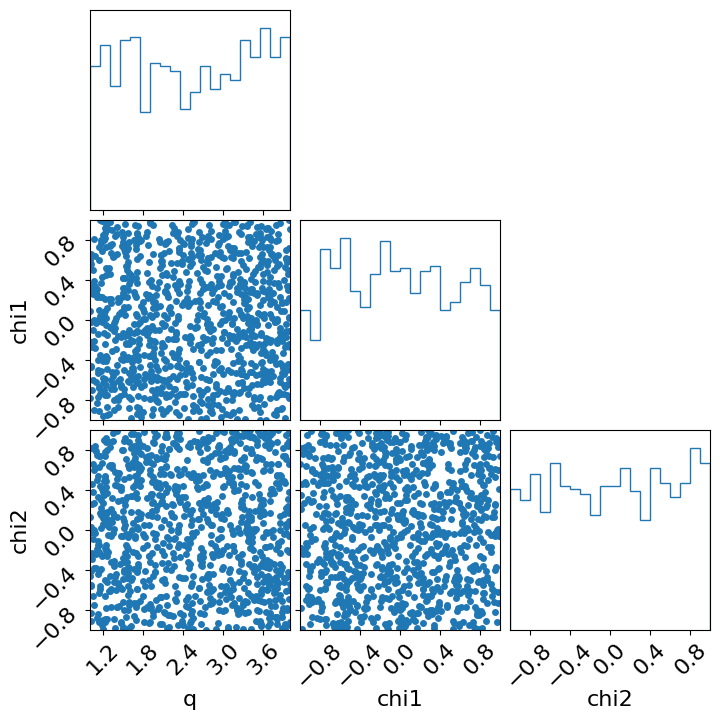

In [567]:
corner.corner(X, labels=feature_names,
              color='C0',
              plot_contours=False, plot_density=False, data_kwargs={'ms':5, 'alpha':1});

In [568]:
def get_amp(q, chi1, chi2, mtotal=100, f_lower=20, delta_t=1/2048., distance=1e-18, inc=0, approximant='IMRPhenomTPHM', start_time=-0.16, end_time=0.05):
    mass1, mass2 = phenom.m1_m2_M_q(mtotal, q)
    spin1z=chi1
    spin2z=chi2
    kwargs=dict(
        approximant='IMRPhenomTPHM',
        mass1=mass1,
        mass2=mass2,
        f_lower=f_lower,
        delta_t=delta_t,
        spin1z=spin1z,
        spin2z=spin2z,
        inclination=inc,
        distance=distance
    )
    hp, hc = pycbc.waveform.get_td_waveform(**kwargs)
    amp = pycbc.waveform.utils.amplitude_from_polarizations(hp, hc)


    # resample
    times = np.linspace(start_time, end_time, 500)
    new_amp = IUS(amp.sample_times, amp.numpy())(times)
    
    new_amp = new_amp / phenom.eta_from_q(q)

    return new_amp


In [569]:
start_time=-0.16
end_time=0.05
times = np.linspace(start_time, end_time, 500)

In [570]:
amps=[]
for i in range(len(X)):
    q=X[i,0]
    chi1=X[i,1]
    chi2=X[i,2]
    amps.append(get_amp(q,chi1, chi2))

In [571]:
new_amps = amps.copy()

In [572]:
new_amps = np.array(new_amps)

In [573]:
# %%time

# f_lower=20
# delta_t=1/2048.

# amps = []
# hps, hcs = [], []
# for i in range(len(X)):
#     mass1=m1s[i]
#     mass2=m2s[i]
#     spin1z=chieffs[i]
#     spin2z=chieffs[i]
#     inc=incs[i]
#     kwargs=dict(
#         approximant='IMRPhenomTPHM',
#         mass1=mass1,
#         mass2=mass2,
#         f_lower=f_lower,
#         delta_t=delta_t,
#         spin1z=spin1z,
#         spin2z=spin2z,
#         inclination=inc,
#         distance=1e-18
#     )
#     hp, hc = pycbc.waveform.get_td_waveform(**kwargs)
#     hps.append(hp)
#     hcs.append(hc)
    
#     amp = pycbc.waveform.utils.amplitude_from_polarizations(hp, hc)
#     amps.append(amp)

In [574]:
# time_limits = []
# for amp in amps:
#     time_limits.append([amp.sample_times.min(), amp.sample_times.max()])
# time_limits = np.array(time_limits)

# common_start_time = time_limits[:,0].max()
# print(f"common_start_time = {common_start_time}")
# # common_end_time = time_limits[:,1].min()
# common_end_time = 0.05

# # resample
# times = np.linspace(common_start_time, common_end_time, 500)
# new_amps = np.array([IUS(amp.sample_times, amp.numpy())(times) for amp in amps])

# # scale = new_amps.max()
# # new_amps = new_amps/scale

# new_amps = new_amps / phenom.eta_from_q(qs)[:,None]


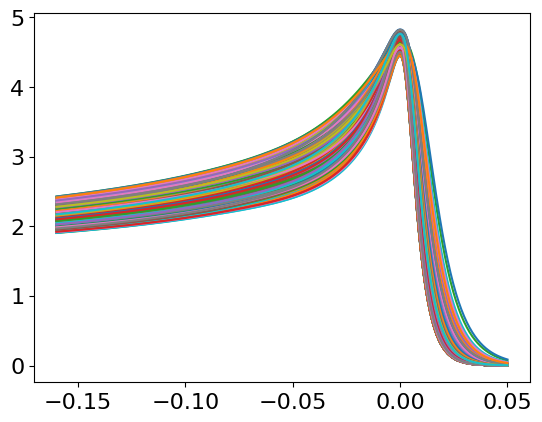

In [575]:
for y in new_amps:
    plt.plot(times, y)

In [576]:
standard_scaler = sklearn.preprocessing.StandardScaler()

In [577]:
new_amps = standard_scaler.fit_transform(new_amps)

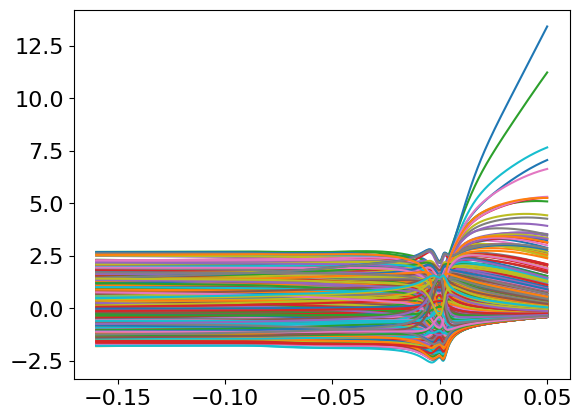

In [578]:
for y in new_amps:
    plt.plot(times, y)

In [579]:
minmax_scaler = sklearn.preprocessing.MinMaxScaler(feature_range=(-1,1))

In [580]:
times_prime = minmax_scaler.fit_transform(times[:,None])[:,0]

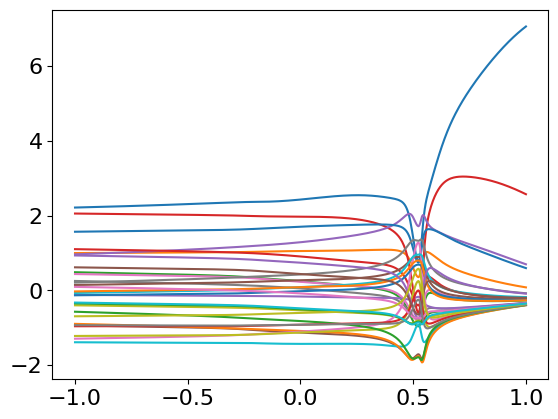

In [581]:
for y in new_amps[:30]:
    plt.plot(times_prime, y)

In [582]:
def compute_pca(y, max_n_components=60, max_variance=0.99):
    # note sure if the how i've implemented the truncated n_components
    pca = sklearn.decomposition.PCA(n_components=max_n_components)
    pca.fit(y)
    variances = pca.explained_variance_ratio_.cumsum()
    n_components_keep = len(variances[variances <= max_variance])

    pca.n_components_ = n_components_keep
    pca.components_ = pca.components_[:n_components_keep]
    pca.singular_values_ = pca.singular_values_[:n_components_keep]
    pca.explained_variance_ratio_ = pca.explained_variance_ratio_[:n_components_keep]

    coeffs = pca.transform(y)
    
    return pca, coeffs

In [583]:
# pca, coeffs = compute_pca(new_amps, max_variance=0.99)
pca, coeffs = compute_pca(new_amps, max_n_components=4, max_variance=1)

In [584]:
coeffs.shape

(1000, 4)

In [585]:
pca.n_components_

4

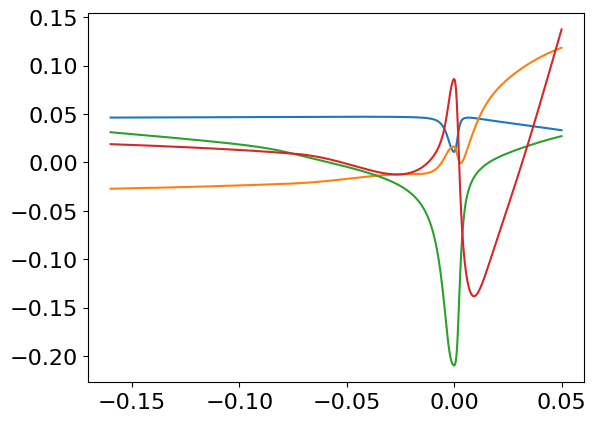

In [586]:
for i in range(pca.n_components_):
    plt.plot(times, pca.components_[i])

In [587]:
idx = np.random.randint(0, len(new_amps))
plt.plot(new_amps[idx])
plt.plot(np.dot(coeffs[idx], pca.components_))
plt.title(f"idx: {idx}")

Text(0.5, 1.0, 'idx: 387')

In [588]:
def compute_clusters(X, n_clusters=10, size_min=20):
    # kmeans = sklearn.cluster.KMeans(n_clusters=n_clusters, n_init='auto').fit(X)
    # labels = kmeans.labels_
    # return kmeans, labels

    
    # gmm = sklearn.mixture.GaussianMixture(n_components=n_clusters, n_init=2).fit(X)
    # labels = gmm.predict(X)
    # return gmm, labels
    clf = KMeansConstrained(
        n_clusters=n_clusters,
        size_min=size_min,
    ).fit(X)

    return clf, clf.labels_

In [589]:
# kmeans, labels_ = compute_clusters(coeffs, n_clusters=14)
# gmm, labels_ = compute_clusters(coeffs, n_clusters=7)
kmeans, labels_ = compute_clusters(coeffs, n_clusters=10, size_min=100)

In [590]:
# once we have clusters we gather together the waveforms in each cluster
# and compute a PCA

In [591]:
np.bincount(labels_)

array([100, 100, 100, 100, 100, 100, 100, 100, 100, 100])

In [592]:
u_labels = np.unique(labels_)

In [593]:
len(u_labels)

10

In [594]:
fig = corner.corner(X[labels_==u_labels[0]], color='C0', labels=feature_names, plot_contours=False, plot_density=False, data_kwargs={'ms':5, 'alpha':1});
for i, u_label in enumerate(u_labels[1:]):
    corner.corner(X[labels_==u_label], color=f'C{i+1}', fig=fig, plot_contours=False, plot_density=False, data_kwargs={'ms':5, 'alpha':1});

In [595]:
# fit a gmm to each cluster
gmms=[]
for l in u_labels:
    gmms.append(sklearn.mixture.GaussianMixture(n_components=5).fit(X[labels_==l]))

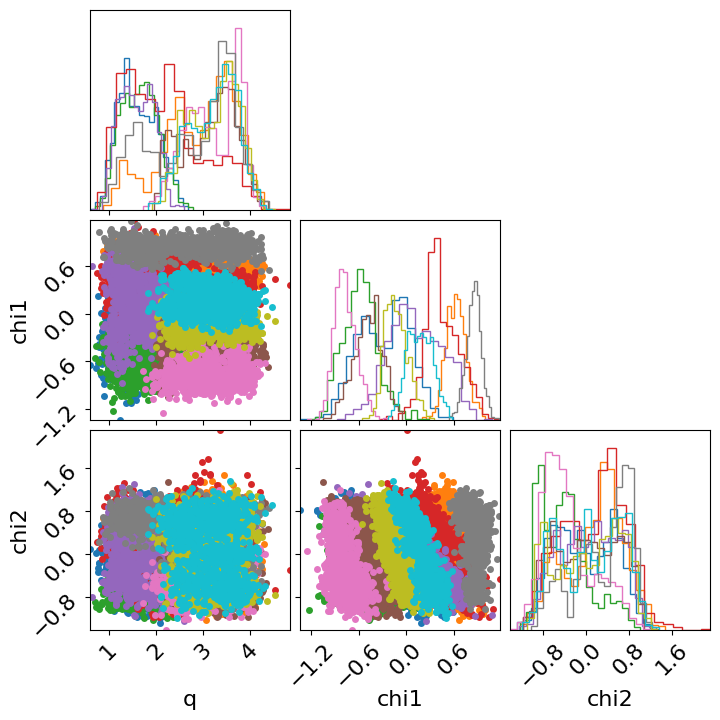

In [596]:
fig = corner.corner(gmms[0].sample(1000)[0], color='C0', labels=feature_names, plot_contours=False, plot_density=False, data_kwargs={'ms':5, 'alpha':1});
for i, u_label in enumerate(u_labels[1:]):
    corner.corner(gmms[u_label].sample(1000)[0], color=f'C{i+1}', fig=fig, plot_contours=False, plot_density=False, data_kwargs={'ms':5, 'alpha':1});

In [597]:
# so when sampling we have to enforce constraints so that we don't have unphysical values
# or we can apply some transformations (bijection) to fix this via mappings.

In [598]:
y_clustered = []
for l in u_labels:
    y_clustered.append(new_amps[labels_==l])

In [599]:
len(y_clustered)

10

In [600]:
# re-centre waveforms in each cluster
y_clustered_prime = []
standard_scalers=[]
for l in u_labels:
    ss = sklearn.preprocessing.StandardScaler()
    y_clustered_prime.append(ss.fit_transform(y_clustered[l]))
    standard_scalers.append(ss)

In [645]:
pcas_=[]
coeffs_=[]
for l in u_labels:
    p_,c_=compute_pca(y=y_clustered_prime[l], max_n_components=len(y_clustered_prime[l]), max_variance=0.99999)
    pcas_.append(p_)
    coeffs_.append(c_)

In [646]:
len(pcas_)

10

In [647]:
[pca_.n_components_ for pca_ in pcas_]

[6, 6, 6, 6, 6, 6, 6, 7, 6, 6]

In [648]:
[pca_.explained_variance_ratio_.sum() for pca_ in pcas_]

[0.9999874197312054,
 0.9999785989602772,
 0.9999896838044184,
 0.9999763738522977,
 0.9999853092270633,
 0.9999835272826288,
 0.999980741909927,
 0.9999829365050347,
 0.9999842557113107,
 0.9999876214651545]

Text(0.5, 1.0, 'idx: 33')

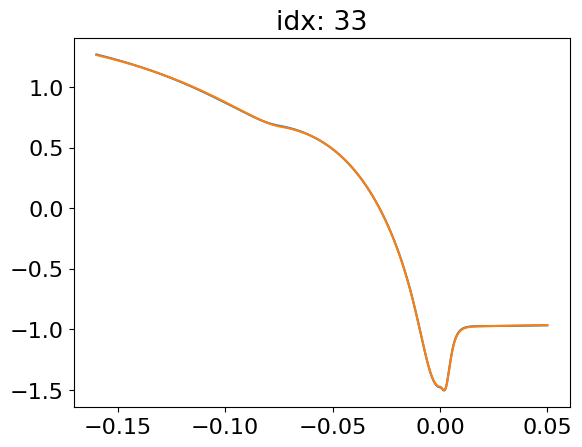

In [649]:
l=5
idx = np.random.randint(0, len(y_clustered_prime[l]))
plt.plot(times, y_clustered_prime[l][idx])
plt.plot(times, np.dot(coeffs_[l][idx], pcas_[l].components_))
plt.title(f"idx: {idx}")
# plt.xlim(-0.1,0.1)

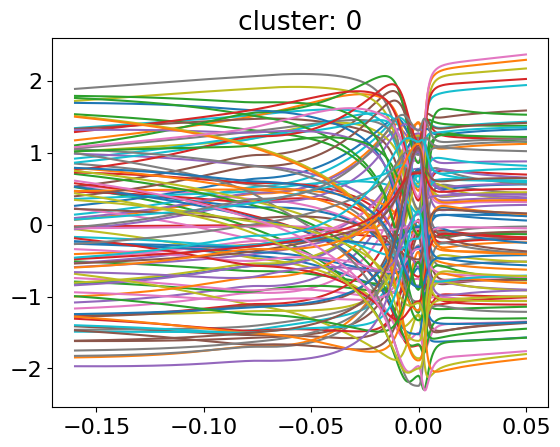

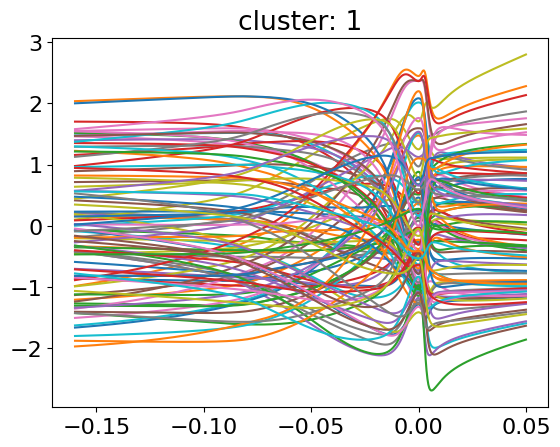

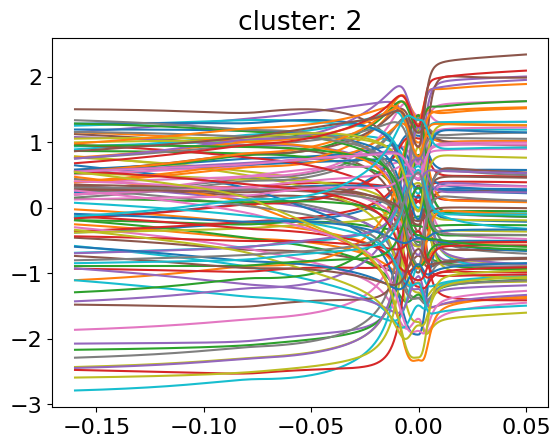

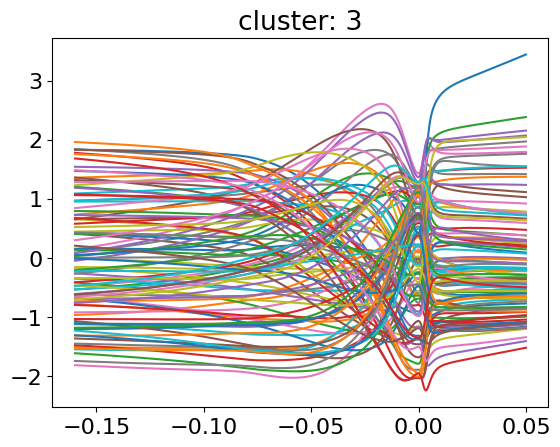

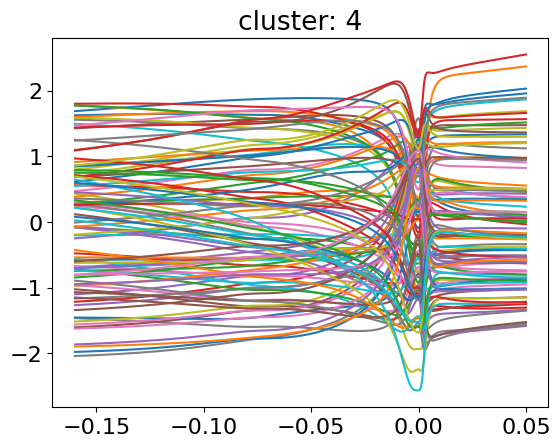

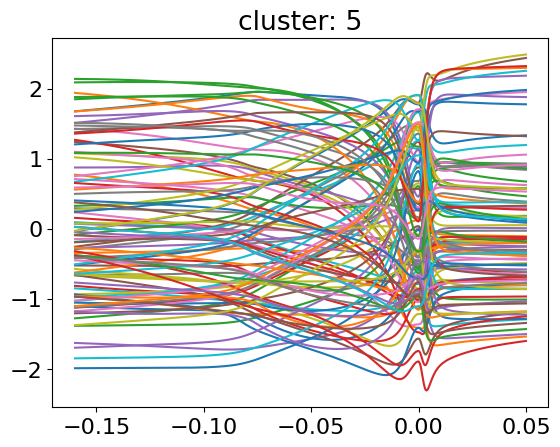

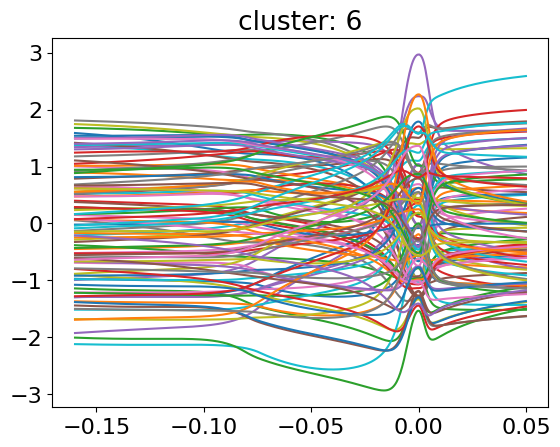

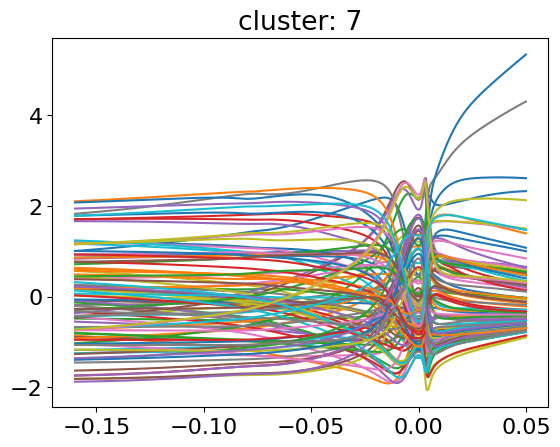

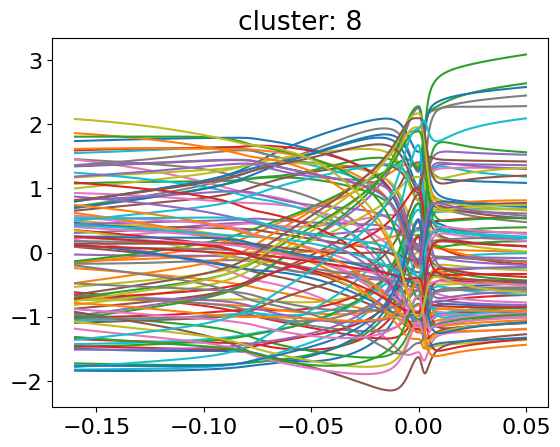

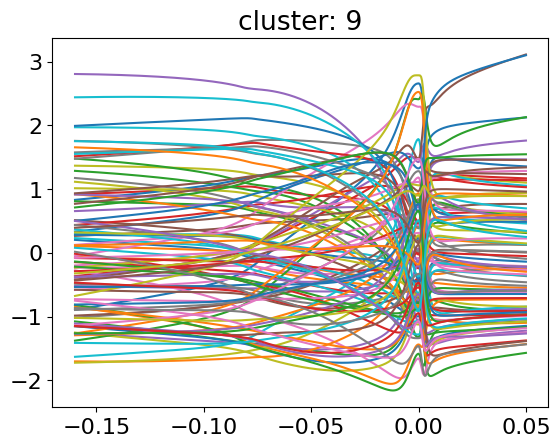

In [650]:
for l in u_labels:
    plt.figure()
    plt.plot(times, y_clustered_prime[l].T)
    plt.title(f"cluster: {l}")
    # plt.xlim(-0.1,0.1)
    plt.show()
    plt.close()

# modelling coefficients

In [651]:
import tensorflow as tf

In [652]:
tf.config.get_visible_devices(
    device_type=None
)[0]

PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')

In [653]:
tf.config.set_visible_devices(tf.config.get_visible_devices(
    device_type=None
)[0])

In [654]:
l=0
coeffs_[l].shape

(100, 6)

In [655]:
output_units = coeffs_[l].shape[1]
output_units

6

In [706]:
# for this cluster sample more waveforms so that we can train the neural network with lots of data
X_new = gmms[l].sample(10000)[0]

In [707]:
# ensure physical spins
# ensure physical q
# ensure physical inc
# X_new = X_new[~((X_new[:,0]<1) | (X_new[:,1]>1) | (X_new[:,1]<-1) | (X_new[:,2]<0) | (X_new[:,2]>2*np.pi))]


X_new = X_new[~((X_new[:,0]<1) | (X_new[:,1]>1) | (X_new[:,1]<-1) | (X_new[:,2]>1) | (X_new[:,2]<-1))]

In [708]:
%%time
amps=[]
# X_new_good = []
for i in range(len(X_new)):
    q=X_new[i,0]
    chi=X_new[i,1]
    inc=X_new[i,2]
    amps.append(get_amp(q,chi,inc))
    # X_new_good.append(X_new[i])
amps = np.array(amps)
# apply first ss
amps_new_prime = standard_scaler.transform(amps)

# then apply second

amps_new_prime = standard_scalers[l].transform(amps_new_prime)

# compute pca coeffs

coeffs_new_ = pcas_[l].transform(amps_new_prime)

CPU times: user 9.58 s, sys: 41.1 s, total: 50.6 s
Wall time: 51.9 s


In [709]:
# X_new = X_new_good

In [710]:
coeffs_new_.shape

(9316, 6)

In [711]:
X_train=X_new
y_train=coeffs_new_

In [712]:
# X_train = X[labels_==u_labels[l]]
# y_train = coeffs_[l]

In [713]:
ss_coeff = sklearn.preprocessing.StandardScaler()
y_train = ss_coeff.fit_transform(y_train)

In [714]:
X_train.shape

(9316, 3)

In [715]:
y_train.shape

(9316, 6)

In [716]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X_train, y_train, test_size=0.33)


In [717]:
X_train.shape

(6241, 3)

In [718]:
X_test.shape

(3075, 3)

In [719]:
# device = '/cpu:0'
# with tf.device(device):
model = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=(3,)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    # tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(output_units, activation='linear'),
])
model.compile(optimizer=tf.keras.optimizers.Adam(1e-3), loss='mse')
# model.predict(np.random.normal(0, 1, size=(1,3)))

In [720]:
%%time
history = model.fit(X_train, y_train, epochs=1000, verbose=0, validation_data=(X_test, y_test), batch_size=32)

CPU times: user 2min 48s, sys: 17.7 s, total: 3min 5s
Wall time: 2min 30s


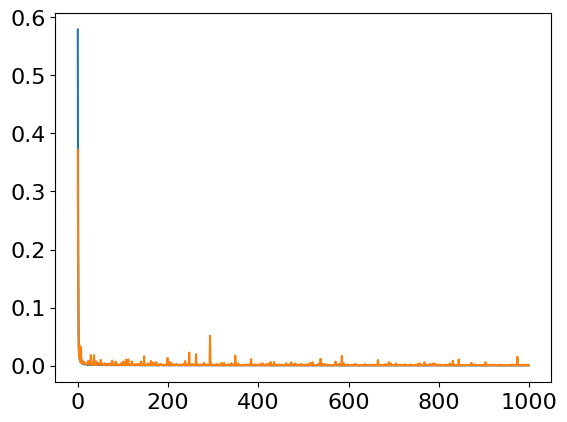

In [721]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

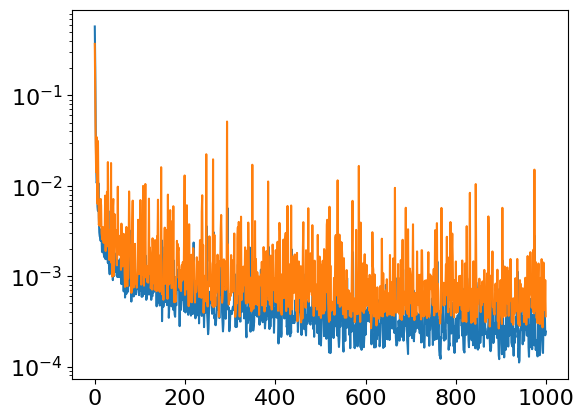

In [722]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.yscale('log')

In [723]:
yhat = model.predict(X_train, verbose=0)

Text(0.5, 1.0, 'idx: 4157')

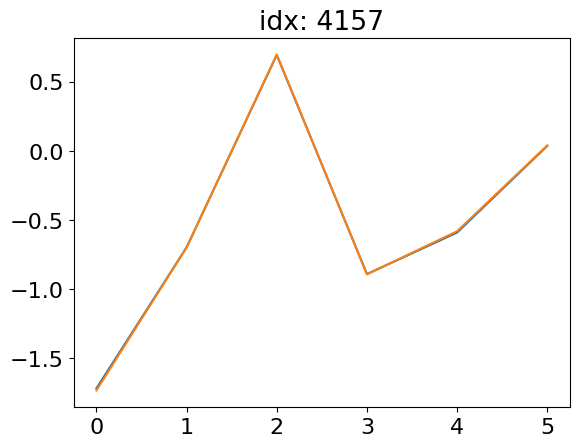

In [724]:
idx = np.random.randint(0,len(y_train))
plt.plot(y_train[idx])
plt.plot(yhat[idx])
plt.title(f"idx: {idx}")

In [725]:
yhat_test = model.predict(X_test, verbose=0)

Text(0.5, 1.0, 'idx: 2912')

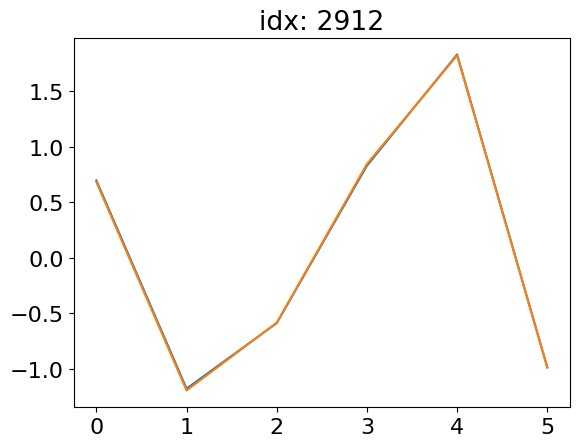

In [735]:
idx = np.random.randint(0,len(y_test))
plt.plot(y_test[idx])
plt.plot(yhat_test[idx])
plt.title(f"idx: {idx}")

In [727]:
yhat__ = model.predict(np.c_[np.linspace(1, 4.5, 100), np.zeros((100, 2))], verbose=0)

In [728]:
plt.plot(np.linspace(1, 4.5, 100), yhat__);